In [9]:
!pip install imantics --quiet

In [10]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [18]:

images_dir =("C:/Users/DRDO SAR/Downloads/archive (2)/train_images")
masks_dir=("C:/Users/DRDO SAR/train_masks")
test_images_dir=("C:/Users/DRDO SAR/Downloads/archive (2)/test_images")



In [19]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(masks_listdir, size = 9, replace = False)
test_images_listdir = os.listdir(test_images_dir)

In [20]:
print(len(images_listdir))
print(len(masks_listdir))

12568
6666


In [21]:
image_size=512
input_image_size=(512,512)

In [22]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

In [23]:
number=500

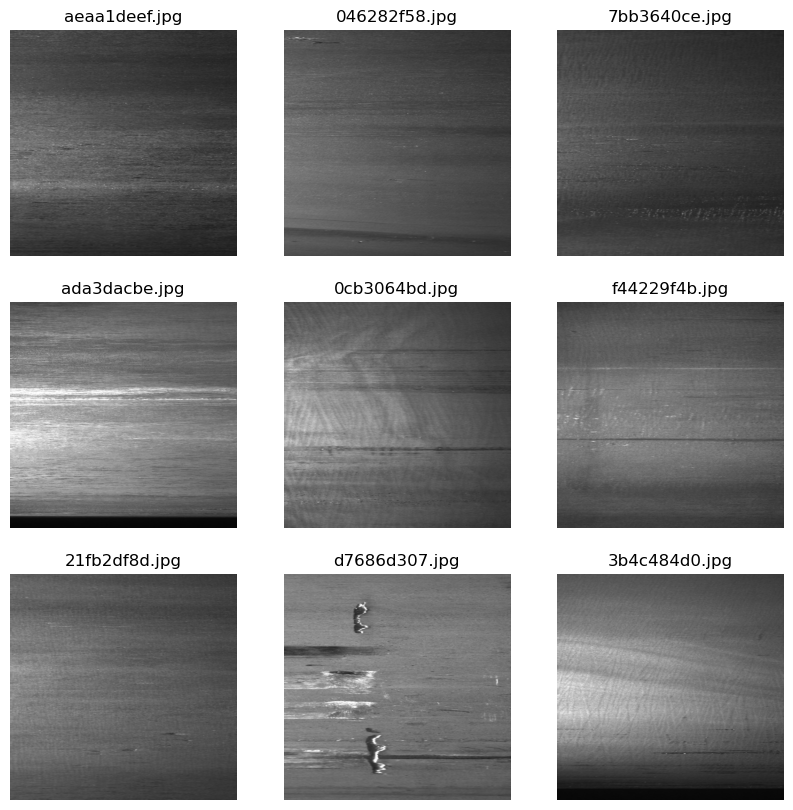

In [24]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        img = np.rot90(img)
        img = np.rot90(img)
        img = np.rot90(img)
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

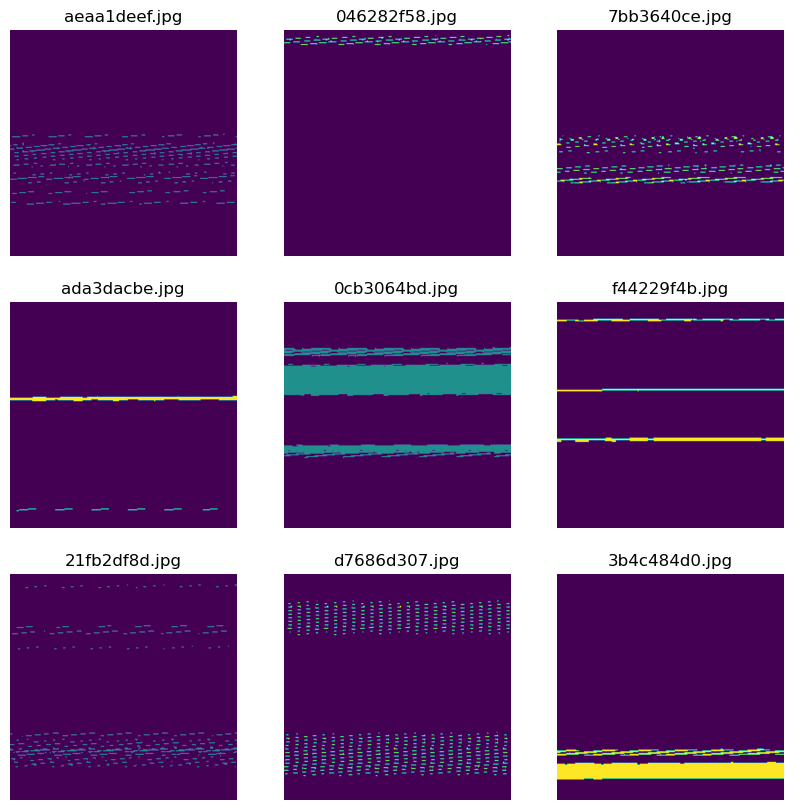

In [25]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [26]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.float16)

for j,file in enumerate(masks_listdir[0:number]): ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image = np.rot90(image)
        image = np.rot90(image)        
        image = np.rot90(image)       
        image_ex = np.expand_dims(image.astype(np.float16), axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        file2=file[0:-4]+'.jpg'
        mask = read_image(f"{masks_dir}/{file2}") 
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask.astype(bool), axis=0)    
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [27]:
TIMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(test_images_listdir[0:number]): ##the smaller, the faster
    try:
        image = read_image(f"{test_images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        TIMAGES = np.vstack([TIMAGES, image_ex])
        
    except:
        print(file)
        continue

In [28]:
images=np.array(IMAGES)[1:number].astype(np.float16)
masks=np.array(MASKS)[1:number]
print(images.shape,masks.shape)

test_images=np.array(TIMAGES)[1:number]
print(test_images.shape,masks.shape)

(499, 512, 512, 3) (499, 512, 512, 1)
(499, 512, 512, 3) (499, 512, 512, 1)


In [30]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.2, random_state=42)

In [31]:
print(len(images_train), len(masks_train))


399 399


In [32]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 512, 512, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512, 512, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 512, 512, 64)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 512, 512, 64)      │          36,928 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 512, 512, 64)      │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 512, 512, 64)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 256, 256, 64)      │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 256, 256, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 256, 256, 128)     │             512 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 256, 256, 128)     │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 256, 256, 128)     │         147,584 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 256, 256, 128)     │             512 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 256, 256, 128)     │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 128, 128, 128)     │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │               

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [33]:
unet_result = unet_model.fit(
    images_train, masks_train, 
    validation_split = 0.2, batch_size = 4, epochs = 5)

Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1316s 16s/step - accuracy: 0.8939 - loss: 0.3303 - val_accuracy: 0.9462 - val_loss: 3.8753
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1301s 16s/step - accuracy: 0.9377 - loss: 0.2096 - val_accuracy: 0.8473 - val_loss: 0.6420
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1307s 16s/step - accuracy: 0.9371 - loss: 0.2129 - val_accuracy: 0.9070 - val_loss: 0.3876
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1298s 16s/step - accuracy: 0.9306 - loss: 0.2281 - val_accuracy: 0.9357 - val_loss: 0.2058
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1305s 16s/step - accuracy: 0.9393 - loss: 0.1914 - val_accuracy: 0.9476 - val_loss: 0.1880


In [34]:
def show_result(og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [35]:
unet_predict = unet_model.predict(images_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 70s 16s/step


In [49]:
unet_predict1 = (unet_predict > 0.1).astype(np.uint8)
unet_predict2 = (unet_predict > 0.2).astype(np.uint8)
unet_predict3 = (unet_predict > 0.3).astype(np.uint8)
unet_predict4 = (unet_predict > 0.4).astype(np.uint8)

In [55]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result(images_test[idx], unet_predict1[idx], masks_test[idx], 0.1)
    show_result(images_test[idx], unet_predict2[idx], masks_test[idx], 0.2)
    show_result(images_test[idx], unet_predict3[idx], masks_test[idx], 0.3)
    show_result(images_test[idx], unet_predict4[idx], masks_test[idx], 0.4)

In [51]:
def show_result2(og, unet, p):
    
    fig, axs = plt.subplots(1, 2, figsize=(12,12))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')

    plt.show()

In [48]:
unet_predictT = unet_model.predict(test_images)

16/16 ━━━━━━━━━━━━━━━━━━━━ 349s 22s/step


In [52]:
unet_predict1 = (unet_predictT > 0.1).astype(np.uint8)
unet_predict2 = (unet_predictT > 0.2).astype(np.uint8)
unet_predict3 = (unet_predictT > 0.3).astype(np.uint8)
unet_predict4 = (unet_predictT > 0.4).astype(np.uint8)

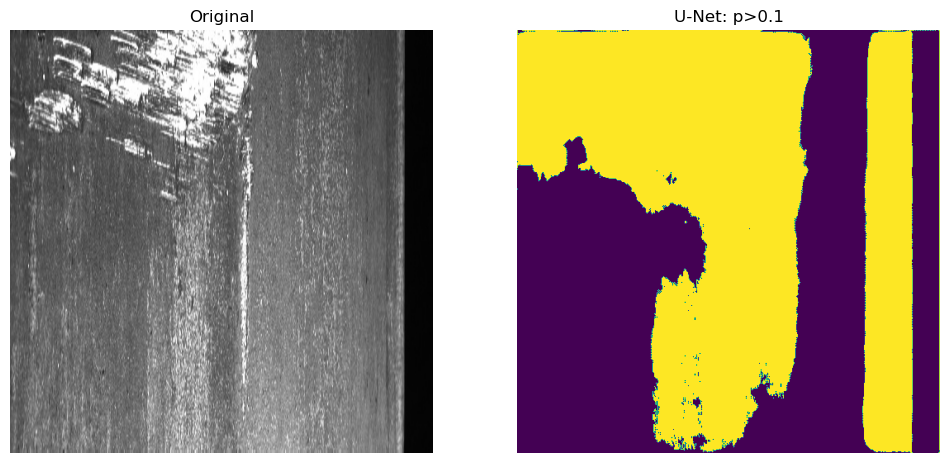

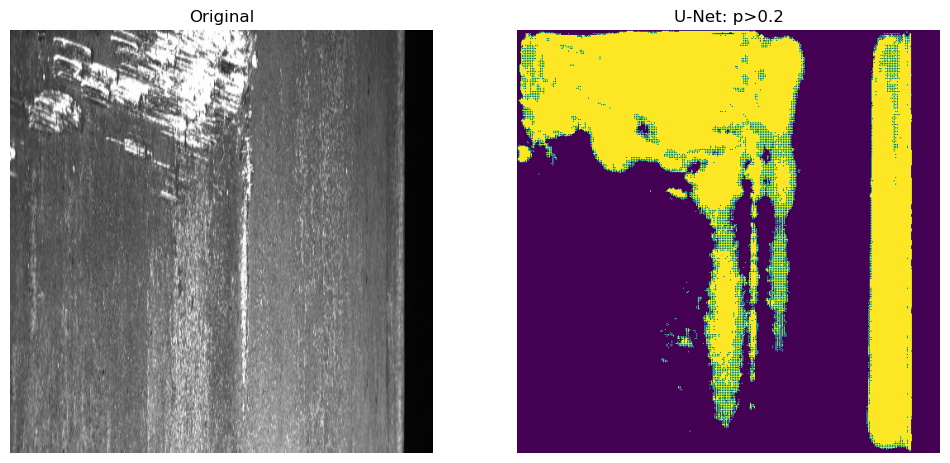

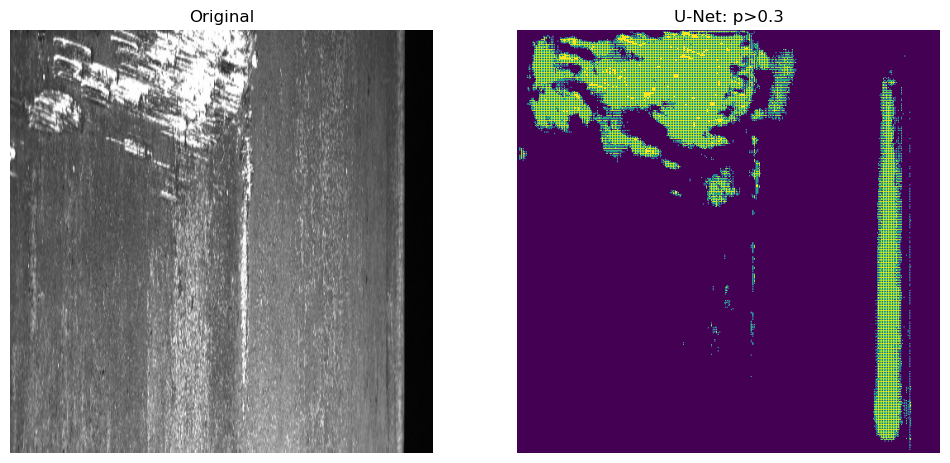

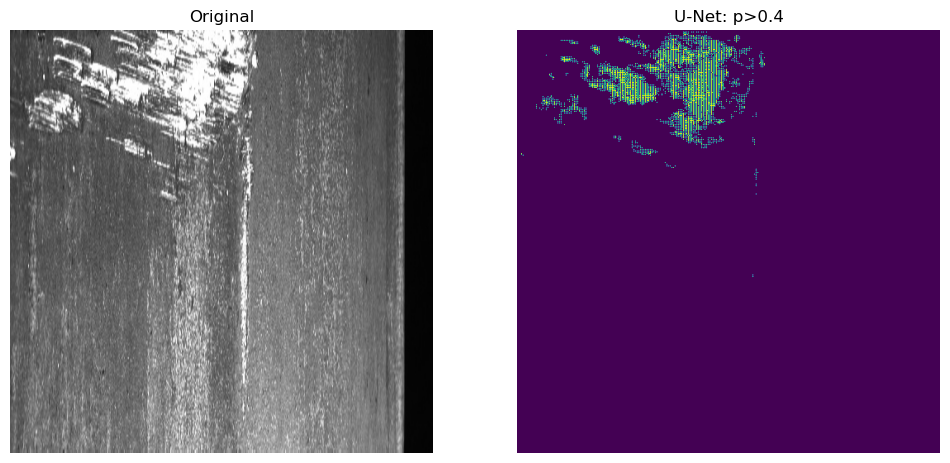

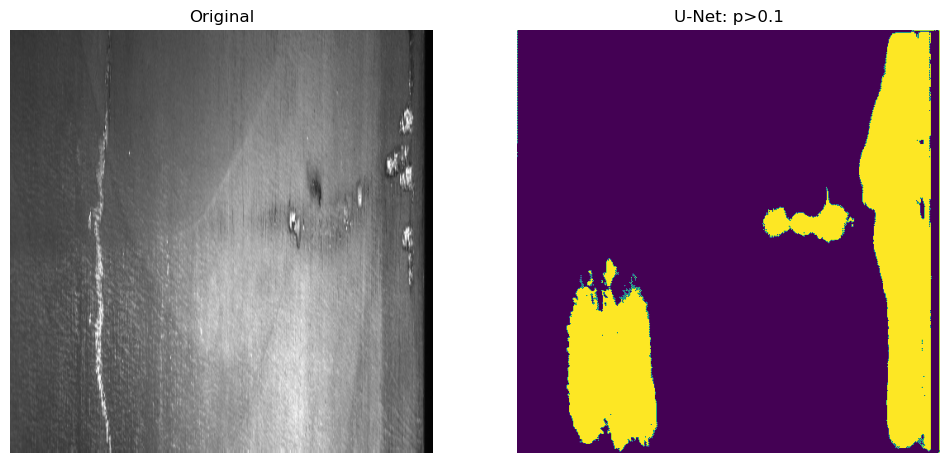

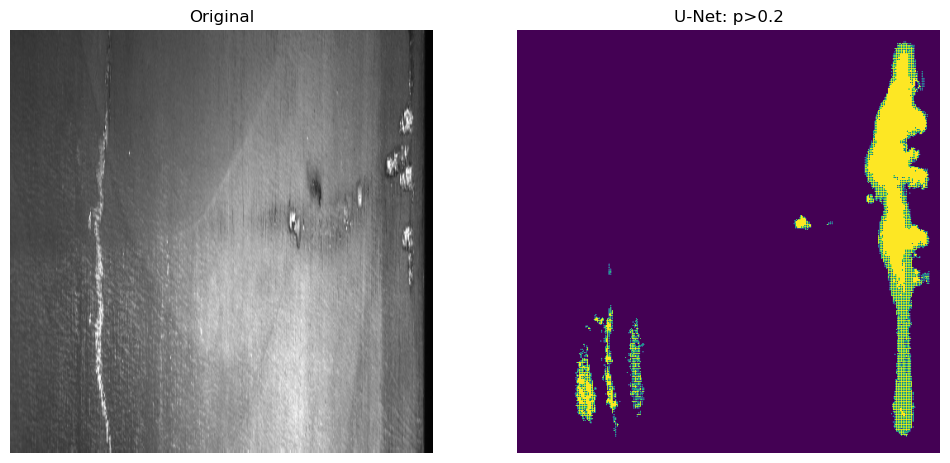

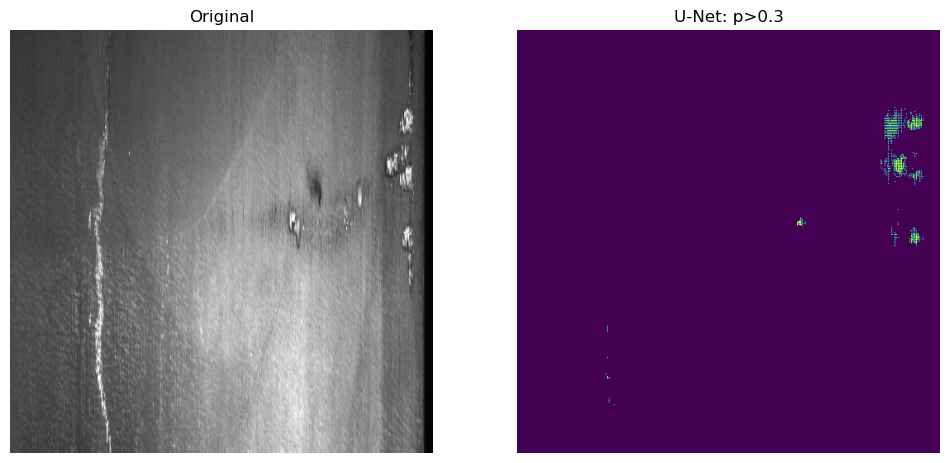

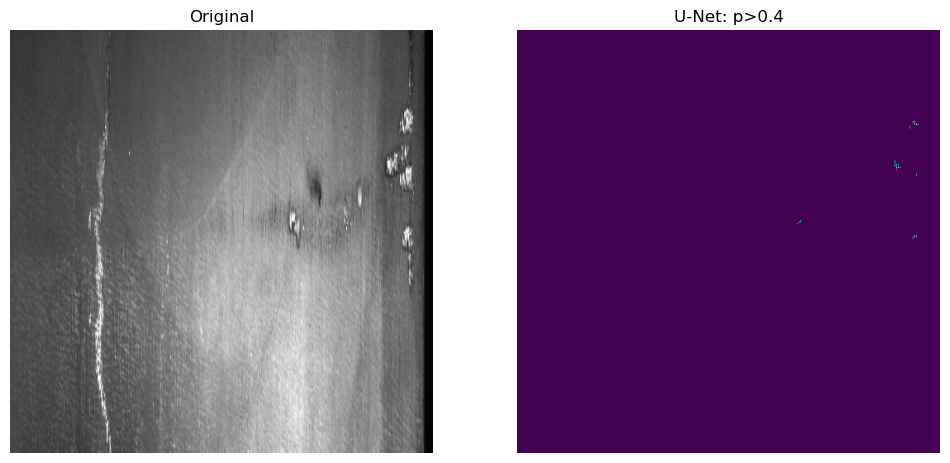

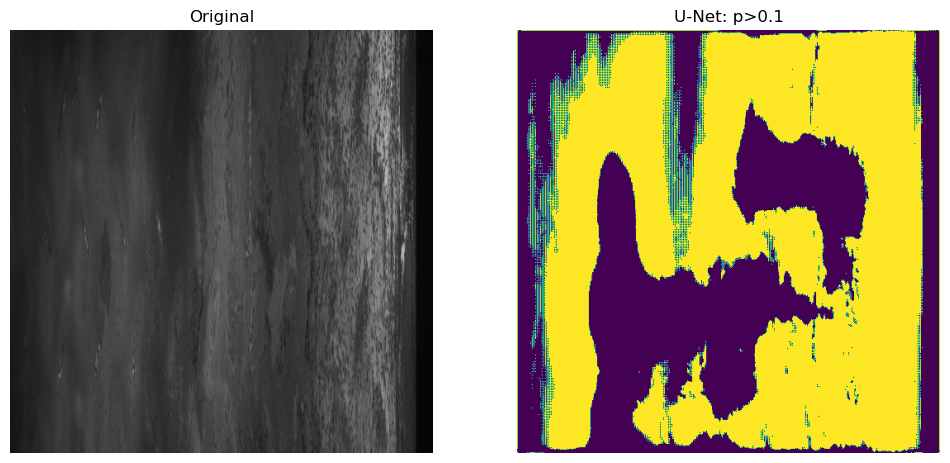

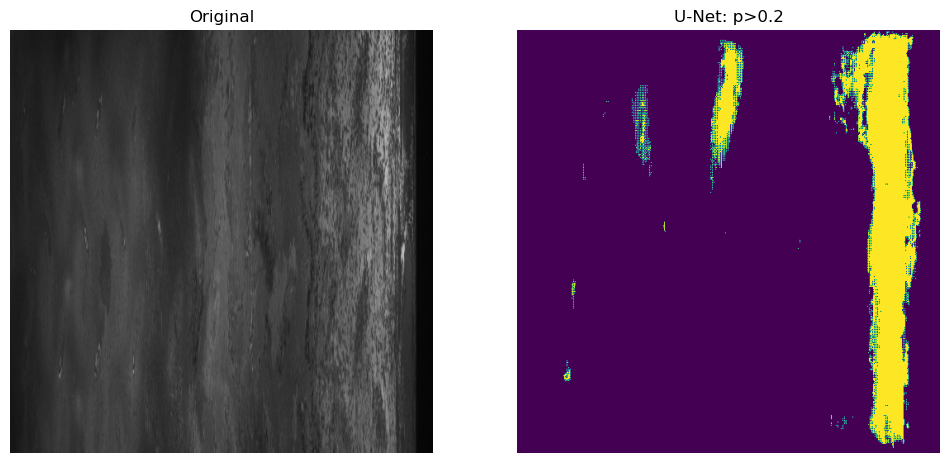

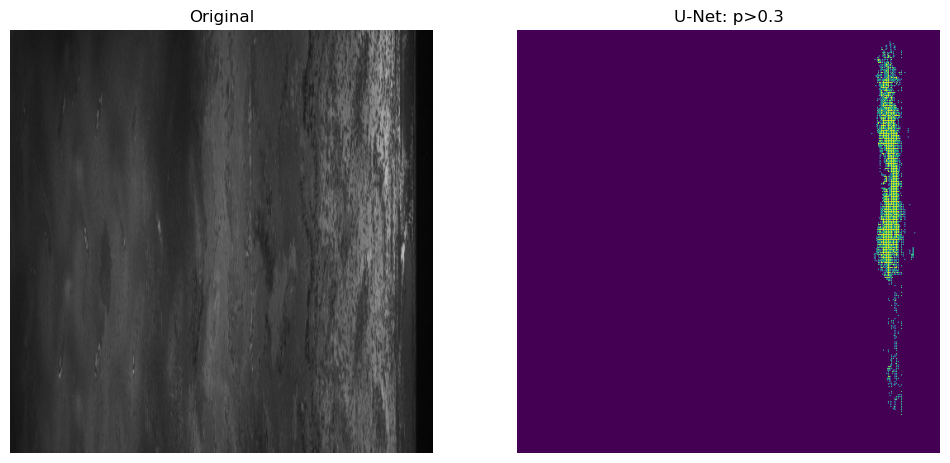

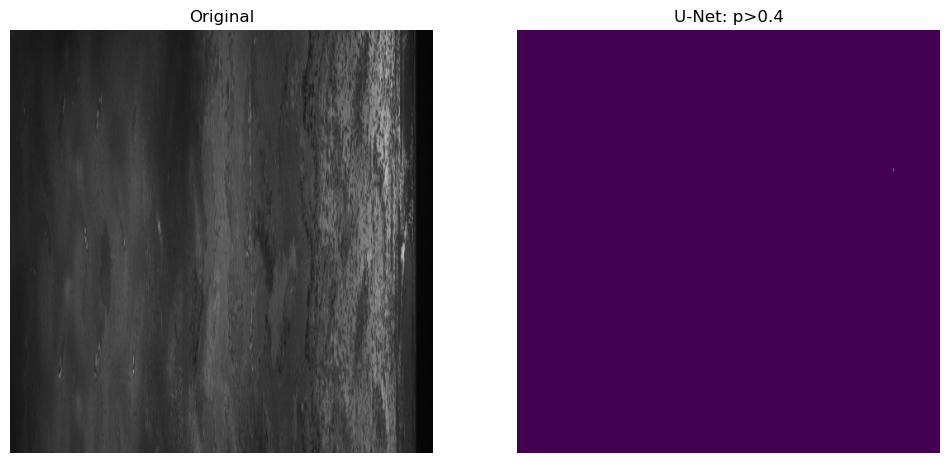

In [54]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result2(test_images[idx], unet_predict1[idx], 0.1)
    show_result2(test_images[idx], unet_predict2[idx], 0.2)
    show_result2(test_images[idx], unet_predict3[idx], 0.3)
    show_result2(test_images[idx], unet_predict4[idx], 0.4)